# Introduction

Brain-Computer Interfaces (BCIs) offer a promising way to help individuals with severe motor or speech impairments communicate using neural signals. One emerging application is imagined speech decoding the ability to recognize internally spoken words using brain activity, without any actual vocalization.

This project explores imagined speech recognition using EEG data (electroencephalography), a non-invasive method for recording electrical brain activity. Using data from the 2020 International BCI Competition, we focus on classifying five imagined phrases: hello, help me, stop, thank you, and yes.

To achieve this, we:

* Apply signal preprocessing and transform EEG segments into a series of 2D topographic brain maps represented as RGB images.

* Train a hybrid deep learning model that combines 3D Convolutional Neural Networks (3D-CNN) and Long Short-Term Memory (LSTM) layers.

* Compare performance across four different EEG channel sets to assess which brain regions contribute most to imagined speech decoding.

* Explore two classification strategies: direct 5-class classification and a nested model that first distinguishes single from compound words.

This notebook presents the full pipeline, from preprocessing and feature generation to model training and evaluation, in a reproducible and step-by-step format.

> ⚠️ **Note**: This notebook demonstrates a focused subset of our full research. We use EEG data from a **single subject** and apply the **direct classification approach** (i.e., 5-class classification of imagined words). Other subjects, channel sets, and classification strategies (such as nested classification) are evaluated in the full study but not shown here for simplicity.


### 📦 Imports and Setup


In [1]:

import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
from scipy.io import loadmat
from scipy.interpolate import griddata
from matplotlib import cm
from skimage import exposure
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models, utils, optimizers
import time


# Dataset Overview

### 📂 Dataset Location

The dataset is stored in the `/kaggle/input/` directory. The following code lists all available files to confirm structure and content.


In [2]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


### 🧰 Helper Functions for `.mat` File Loading

The EEG dataset is stored in MATLAB `.mat` format. The following helper functions allow recursive conversion of nested MATLAB structs into standard Python dictionaries.


In [3]:
# === Helper function to recursively convert mat_struct to dictionary ===
def _check_keys(d):
    for key in d:
        if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
            d[key] = _todict(d[key])
    return d

def _todict(matobj):
    d = {}
    for strg in matobj._fieldnames:
        elem = getattr(matobj, strg)
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            d[strg] = _todict(elem)
        else:
            d[strg] = elem
    return d

### 📥 Load EEG Sample Data

The dataset is provided in MATLAB `.mat` format. Below is an example of how one subject's data file is loaded and converted into a Python-readable structure.

In this notebook, we load EEG data from one subject only for demonstration purposes.



In [4]:
# === Load the .mat file ===
file_path = "BCI2020 EEG Signal for Words/Training set/Data_Sample01.mat"
mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
mat_data = _check_keys(mat_data)

/tmp/ipykernel_1557/1956363914.py:4: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(d[key], scipy.io.matlab.mio5_params.mat_struct):
/tmp/ipykernel_1557/1956363914.py:12: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):


### 📊 Explore EEG Data Structure

After loading the `.mat` file, we extract:
- The EEG signal matrix
- The class labels
- Electrode coordinates used later for image generation


In [5]:
# === Access the contents ===
epo_train = mat_data['epo_train']
mnt = mat_data['mnt']

# === Accessing epo_train fields
data = epo_train['x']           # EEG data: shape (samples, channels, trials)
labels = epo_train['y']         # Labels: shape (num_classes, trials)

# === Accessing mnt fields (channel positions)
mnt_x = mnt['x'][0]             # x-coordinates: (64,)
mnt_y = mnt['y'][0]             # y-coordinates: (64,)

### 🔍 Inspect Data Structure

We inspect the keys available in the loaded EEG and metadata structures to better understand how to access relevant fields.


In [6]:
# Example access:
print("epo_train keys:", epo_train.keys())
print("mnt keys:", mnt.keys())

epo_train keys: dict_keys(['clab', 'fs', 'title', 'file', 'x', 'y', 't', 'className'])
mnt keys: dict_keys(['x', 'y', 'pos_3d', 'clab'])


### 🧭 EEG Channel Mapping and Set Definitions

We define a mapping between EEG channel labels and their numerical indices for easier selection and analysis. Additionally, several channel sets are specified based on prior research and neuroanatomical relevance to speech processing.


In [7]:
# === Channel Labeling ===
label_to_channel = {
    'Fp1': 1, 'Fp2': 2, 'F7': 3, 'F3': 4, 'Fz': 5, 'F4': 6,
    'F8': 7, 'FC5': 8, 'FC1': 9, 'FC2': 10, 'FC6': 11, 'T7': 12,
    'C3': 13, 'Cz': 14, 'C4': 15, 'T8': 16, 'TP9': 17, 'CP5': 18,
    'CP1': 19, 'CP2': 20, 'CP6': 21, 'TP10': 22, 'P7': 23, 'P3': 24,
    'Pz': 25, 'P4': 26, 'P8': 27, 'PO9': 28, 'O1': 29, 'Oz': 30,
    'O2': 31, 'PO10': 32, 'AF7': 33, 'AF3': 34, 'AF4': 35, 'AF8': 36,
    'F5': 37, 'F1': 38, 'F2': 39, 'F6': 40, 'FT9': 41, 'FT7': 42,
    'FC3': 43, 'FC4': 44, 'FT8': 45, 'FT10': 46, 'C5': 47, 'C1': 48,
    'C2': 49, 'C6': 50, 'TP7': 51, 'CP3': 52, 'CPz': 53, 'CP4': 54,
    'TP8': 55, 'P5': 56, 'P1': 57, 'P2': 58, 'P6': 59, 'PO7': 60,
    'PO3': 61, 'POz': 62, 'PO4': 63, 'PO8': 64
}


# 14 Channels available by EMOTIV EPOC headset
Channels1 = ["AF3","F7","F3","FC5","T7","P7","O1","O2","P8","T8","FC6","F4","F8","AF4"]  

# 15 Channels - Research [14] claimed these brain regions are significantly associated with imagined speech
Channels2 = ["AF3","F7","F3","F4","F8","AF4","AF7","AF8","Fp1","Fp2","F2","F6","Fz","F1","F5"] 

# Left-Hemisphere Dominance in Language Processing
Channels3 = ["F7","F3","FC5","T7","P7","C3"]  

# Subject-Specific Channel Selection Using Utility Metrics
Channels4 = ["F7","F3","FC5","FC6","F4","T7","T8","C3","C4","P7","P8","O1","O2","CP5","CP6","Cz","P3","P4","POz"]  

# Targeting Frontal and Central Regions
Channels5 = ["F3","FC5","C3","F4","FC6","C4","Cz"]  


# Preprocessing

### 🧮 Segmentation Parameters

The EEG signal is divided into overlapping windows for time-series analysis and image generation. The parameters below define the window size, overlap, and the number of segments per trial.


In [8]:
# === Parameters ===
fs = 256               # Sampling frequency (Hz)
win_ms = 125           # Window length (milliseconds)
overlap_percent = 50   # Desired overlap (in percentage)

# === Calculations ===
win_samples = round(fs * win_ms / 1000)                      # Samples per window
overlap_samples = round(win_samples * overlap_percent / 100)  # Overlap samples
step_samples = win_samples - overlap_samples                 # Step size
total_samples = epo_train['x'].shape[0]  # Total time samples (e.g., 795)


n_maps = int(np.floor((total_samples - overlap_samples) / step_samples))  # Number of windows/maps

### 🎯 Channel Selection

From the full 64-channel EEG data, we select a specific group of channels that are believed to be relevant to imagined speech processing. These groups were defined earlier based on neurophysiological studies and experimental goals.

In this notebook, we manually choose **one** of those predefined sets (e.g., `Channels2`) for demonstration. You can switch to any of the other sets (`Channels1`, `Channels3`, etc.) by simply updating the selection in the code below.


In [9]:
# == Selecting the Channels ==

# Select the channel
selected = Channels4 # Select which channel group you would like to use 

# Preallocate
selected_channels = np.zeros(len(selected), dtype=int)

# Map each label to its corresponding index using the dictionary
for i in range(len(selected)):
    selected_channels[i] = label_to_channel[selected[i]]


### 🖼️ EEG-to-Image Setup and Map Selection

To transform EEG signals into 2D topographic images, we define the resolution of the generated maps and prepare a coordinate grid for spatial interpolation. This allows us to convert EEG values from selected channels into RGB-encoded images.

Although each trial is segmented into multiple overlapping windows (or "maps"), only a specific subset is used for classification. The range from map 6 to map 44 is selected based on empirical observations of where the most meaningful neural activity tends to occur during imagined speech tasks.


In [10]:
# === MAP PARAMETERS ===
map_size = 32

# Select x and y coordinates for selected channels
x_sel = mnt['x'][selected_channels]
y_sel = mnt['y'][selected_channels]

# Create meshgrid for interpolation
xi, yi = np.meshgrid(
    np.linspace(np.min(x_sel), np.max(x_sel), map_size),
    np.linspace(np.min(y_sel), np.max(y_sel), map_size)
)

# Range of maps
start_map = 6
end_map = 44
tot_map = end_map - start_map + 1

# Number of training trials
n_train_trials = epo_train['x'].shape[2]  # assuming shape is [time, channels, trials]

In [11]:
# === Notch Filter Parameters ===
fs = 256  # Sampling frequency
f0 = 40   # Notch frequency
Q = 35    # Quality factor

# === Compute filter coefficients for notch filter ===
w0 = 2 * np.pi * f0 / fs
alpha = np.sin(w0) / (2 * Q)

b_notch = np.array([1, -2 * np.cos(w0), 1]) / (1 + alpha)
a_notch = np.array([1 + alpha, -2 * np.cos(w0), 1 - alpha]) / (1 + alpha)

# === Copy data to preserve original
all_data = epo_train['x']  # shape: (samples, channels, trials)
filtered_data = np.copy(all_data)

# === Apply notch filter channel-by-channel and trial-by-trial
n_trials = filtered_data.shape[2]
n_channels = filtered_data.shape[1]

for t in range(n_trials):
    for ch in range(n_channels):
        signal = filtered_data[:, ch, t]
        filtered_data[:, ch, t] = filtfilt(b_notch, a_notch, signal)

# === Apply CAR referencing (per trial)
for t in range(n_trials):
    trial = filtered_data[:, :, t]
    trial = trial - np.mean(trial, axis=1, keepdims=True)
    filtered_data[:, :, t] = trial

# === Save back to structure
epo_train_car = dict(epo_train)  # Clone the structure
epo_train_car['x'] = filtered_data  # Update with filtered and CAR-applied data

# Feature Engineering

### 🧠 EEG-to-Image Conversion

Each EEG trial is segmented into overlapping time windows. For each segment:
- The average signal across selected channels is computed.
- These values are interpolated across a 2D scalp map.
- The interpolated matrix is normalized and mapped to RGB using a jet colormap.

The result is a sequence of RGB topographic brain maps per trial, which form the input features for the deep learning model.


In [12]:
# === Initialize
map_size = xi.shape[0]  # Assuming square: 64x64 or custom
topo_maps_rgb_5D = np.zeros((map_size, map_size, 3, n_maps, n_train_trials))  # [H x W x 3 x T x N]

# === Main Loop Over Trials
for t in range(n_train_trials):
    # Extract trial & selected channels: [time x channels]
    data = epo_train_car['x'][:, selected_channels, t]

    for w in range(n_maps):
        start_idx = (w) * step_samples
        end_idx = start_idx + win_samples

        if end_idx > total_samples:
            break

        # 1. Mean EEG over window [1 x channels]
        segment = np.mean(data[start_idx:end_idx, :], axis=0)
        segment = segment.astype(np.float64).flatten()

        # 2. Interpolation to 2D grid
        zi = griddata((x_sel.flatten(), y_sel.flatten()), segment,
                      (xi, yi), method='cubic')

        # 3. Normalize to [0, 1]
        zi_min, zi_max = np.nanmin(zi), np.nanmax(zi)
        zi_norm = (zi - zi_min) / (zi_max - zi_min + np.finfo(float).eps)

        # 4. Convert to RGB using jet colormap
        cmap = cm.get_cmap('jet', 256)
        rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]  # drop alpha channel

        # 5. Store in array
        topo_maps_rgb_5D[:, :, :, w, t] = rgb_map

# === Final reshaping for CNN input: [H x W x 3 x tot_map x num_trials]
topo_maps_rgb_5D = topo_maps_rgb_5D[:, :, :, start_map-1:end_map, :]
topo_maps_rgb_5D = topo_maps_rgb_5D.reshape((map_size, map_size, 3, tot_map, -1))

/tmp/ipykernel_1557/3373171260.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', 256)
/tmp/ipykernel_1557/3373171260.py:31: RuntimeWarning: invalid value encountered in cast
  rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]  # drop alpha channel


### 🎲 Random Topographic Map Visualization

This cell selects and displays a **single random EEG topographic map** from the dataset. A trial is chosen at random, and one corresponding map (time window) is randomly selected from its sequence.

Each map represents spatial brain activity at a specific time window during the imagined speech task, visualized in RGB using the `jet` colormap.

This quick visualization helps inspect the quality and variety of individual EEG maps across different trials without plotting the full sequence.


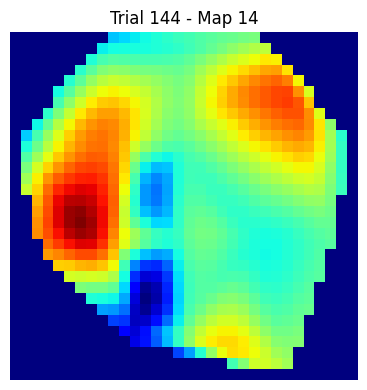

In [13]:
import random

# === Get shape information
H, W, _, T, N = topo_maps_rgb_5D.shape

# === Select a random trial and map index
random_trial = random.randint(0, N - 1)
random_map = random.randint(0, T - 1)

# === Extract the specific map
img = topo_maps_rgb_5D[:, :, :, random_map, random_trial]

# === Plot the selected map
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f'Trial {random_trial + 1} - Map {random_map + 1}')
plt.axis('off')
plt.tight_layout()
plt.show()


### 🖼️ Visualize EEG Topographic Maps (RGB)

Below, we display all generated topographic maps for a single EEG trial. Each image represents brain activity over a 125 ms window, transformed into a spatial RGB map using interpolation and colormapping.


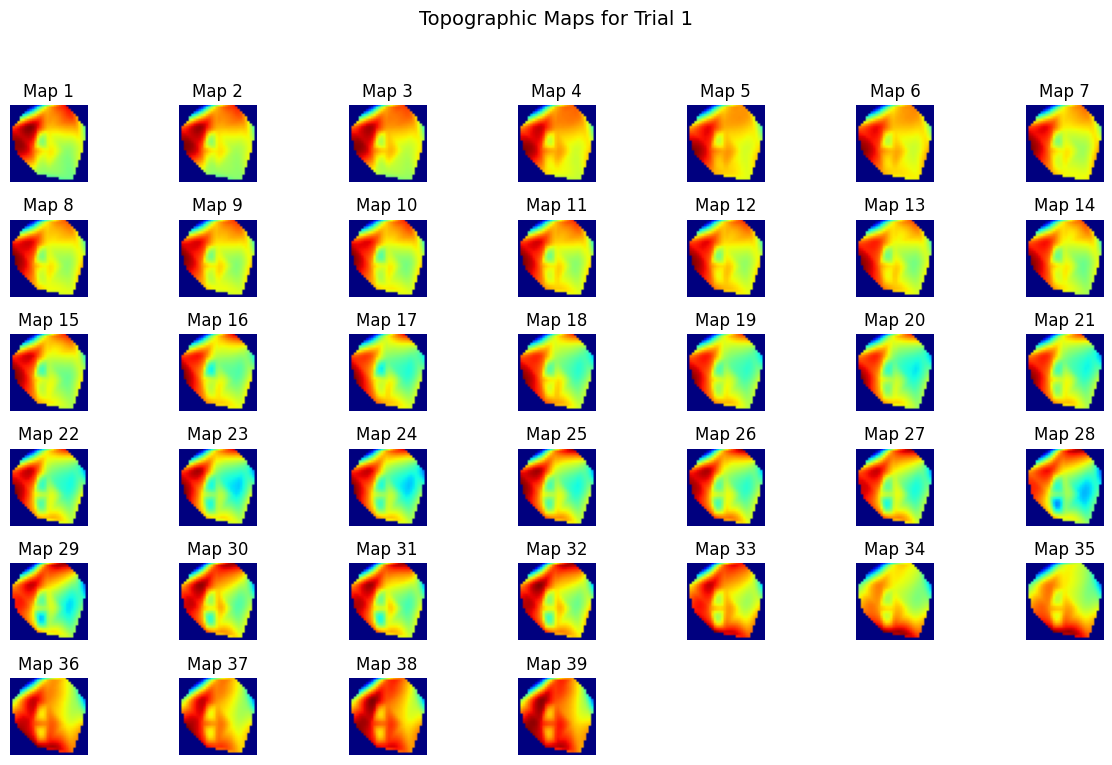

In [14]:
# Parameters
sample_trial = 0  # Python uses 0-based indexing (0 to N-1)
H, W, _, T, N = topo_maps_rgb_5D.shape

if sample_trial < 0 or sample_trial >= N:
    raise ValueError(f"Invalid trial index. Must be between 0 and {N-1}")

# Plotting
plt.figure(figsize=(12, 8))
plt.suptitle(f'Topographic Maps for Trial {sample_trial + 1}', fontsize=14)

cols = int(np.ceil(np.sqrt(T)))
rows = int(np.ceil(T / cols))

for i in range(T):
    plt.subplot(rows, cols, i + 1)
    img = topo_maps_rgb_5D[:, :, :, i, sample_trial]
    plt.imshow(img)
    plt.title(f'Map {i + 1}')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 🏷️ Extract and Format Class Labels

The dataset stores labels as one-hot encoded vectors (shape: 5 × num_trials). We convert these into integer class indices and then map them to human-readable class names. A shape check is also performed to validate label integrity.


In [15]:
# Assuming 'epo_train' is a dictionary and 'y' is a numpy array with shape (5, 300)
label_vector = epo_train['y']  # shape: (5, 300)

# === Validate shape
assert label_vector.shape[0] == 5, "Expected 5 rows for one-hot classes."
n_samples = label_vector.shape[1]

# === Convert from one-hot to class indices [0–4]
label_idx = np.argmax(label_vector, axis=0)  # shape: (300,)

# === Class names (adjust if different)
classNames = np.array(["Hello", "Help me", "Stop", "Thank you", "Yes"])

# === Create categorical label vector
labels = pd.Categorical(classNames[label_idx])

# Classification

### 🧠 Model Architecture — 3D CNN

We define a 3D Convolutional Neural Network (3D-CNN) that processes the spatiotemporal EEG image sequences. The model includes three convolutional layers with max pooling, followed by dense layers with dropout regularization.


In [16]:
# === Input shape and class count
inputSize = (map_size, map_size, 3, tot_map)  # [H, W, C, T]
numClasses = len(np.unique(labels))

# === Define 3D-CNN model
model = models.Sequential([
    layers.InputLayer(input_shape=inputSize),                       # [H, W, C, T]

    layers.Conv3D(32, 3, padding='same', activation='relu'),        # 3D conv over space + time
    layers.MaxPooling3D(pool_size=(2, 2, 1)),                       # Pool over H x W only

    layers.Conv3D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling3D(pool_size=(2, 2, 1)),

    layers.Conv3D(128, 3, padding='same', activation='relu'),
    
    layers.Permute((4, 1, 2, 3)),                                   # Now shape = [T, H', W', C]
    layers.TimeDistributed(layers.Flatten()),                      # Flattens each time slice
    layers.LSTM(128, return_sequences=False),                      # LSTM over time dimension

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(numClasses, activation='softmax')
])
# === Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


/home/darkrai/tfenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1760097379.466254    1557 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### 🧠 Model Architecture Overview

To understand and interpret the structure of the trained model, we include both a visual diagram and a textual summary:

- **Visual Diagram**  
  A high-level graphical representation illustrates the overall architecture, showing:
  - The sequence of layers  
  - Layer types and names  
  - Input and output tensor shapes  
  This helps visualize how data flows through the network and supports documentation or presentation.

- **Text Summary**  
  A detailed, layer-by-layer table presents:
  - Output shapes of each layer  
  - Number of trainable parameters  
  - Layer names and types  
  This textual breakdown is useful for verifying model complexity, debugging, and model optimization.

These combined tools provide a clear and comprehensive view of the network architecture and support model transparency and reproducibility.


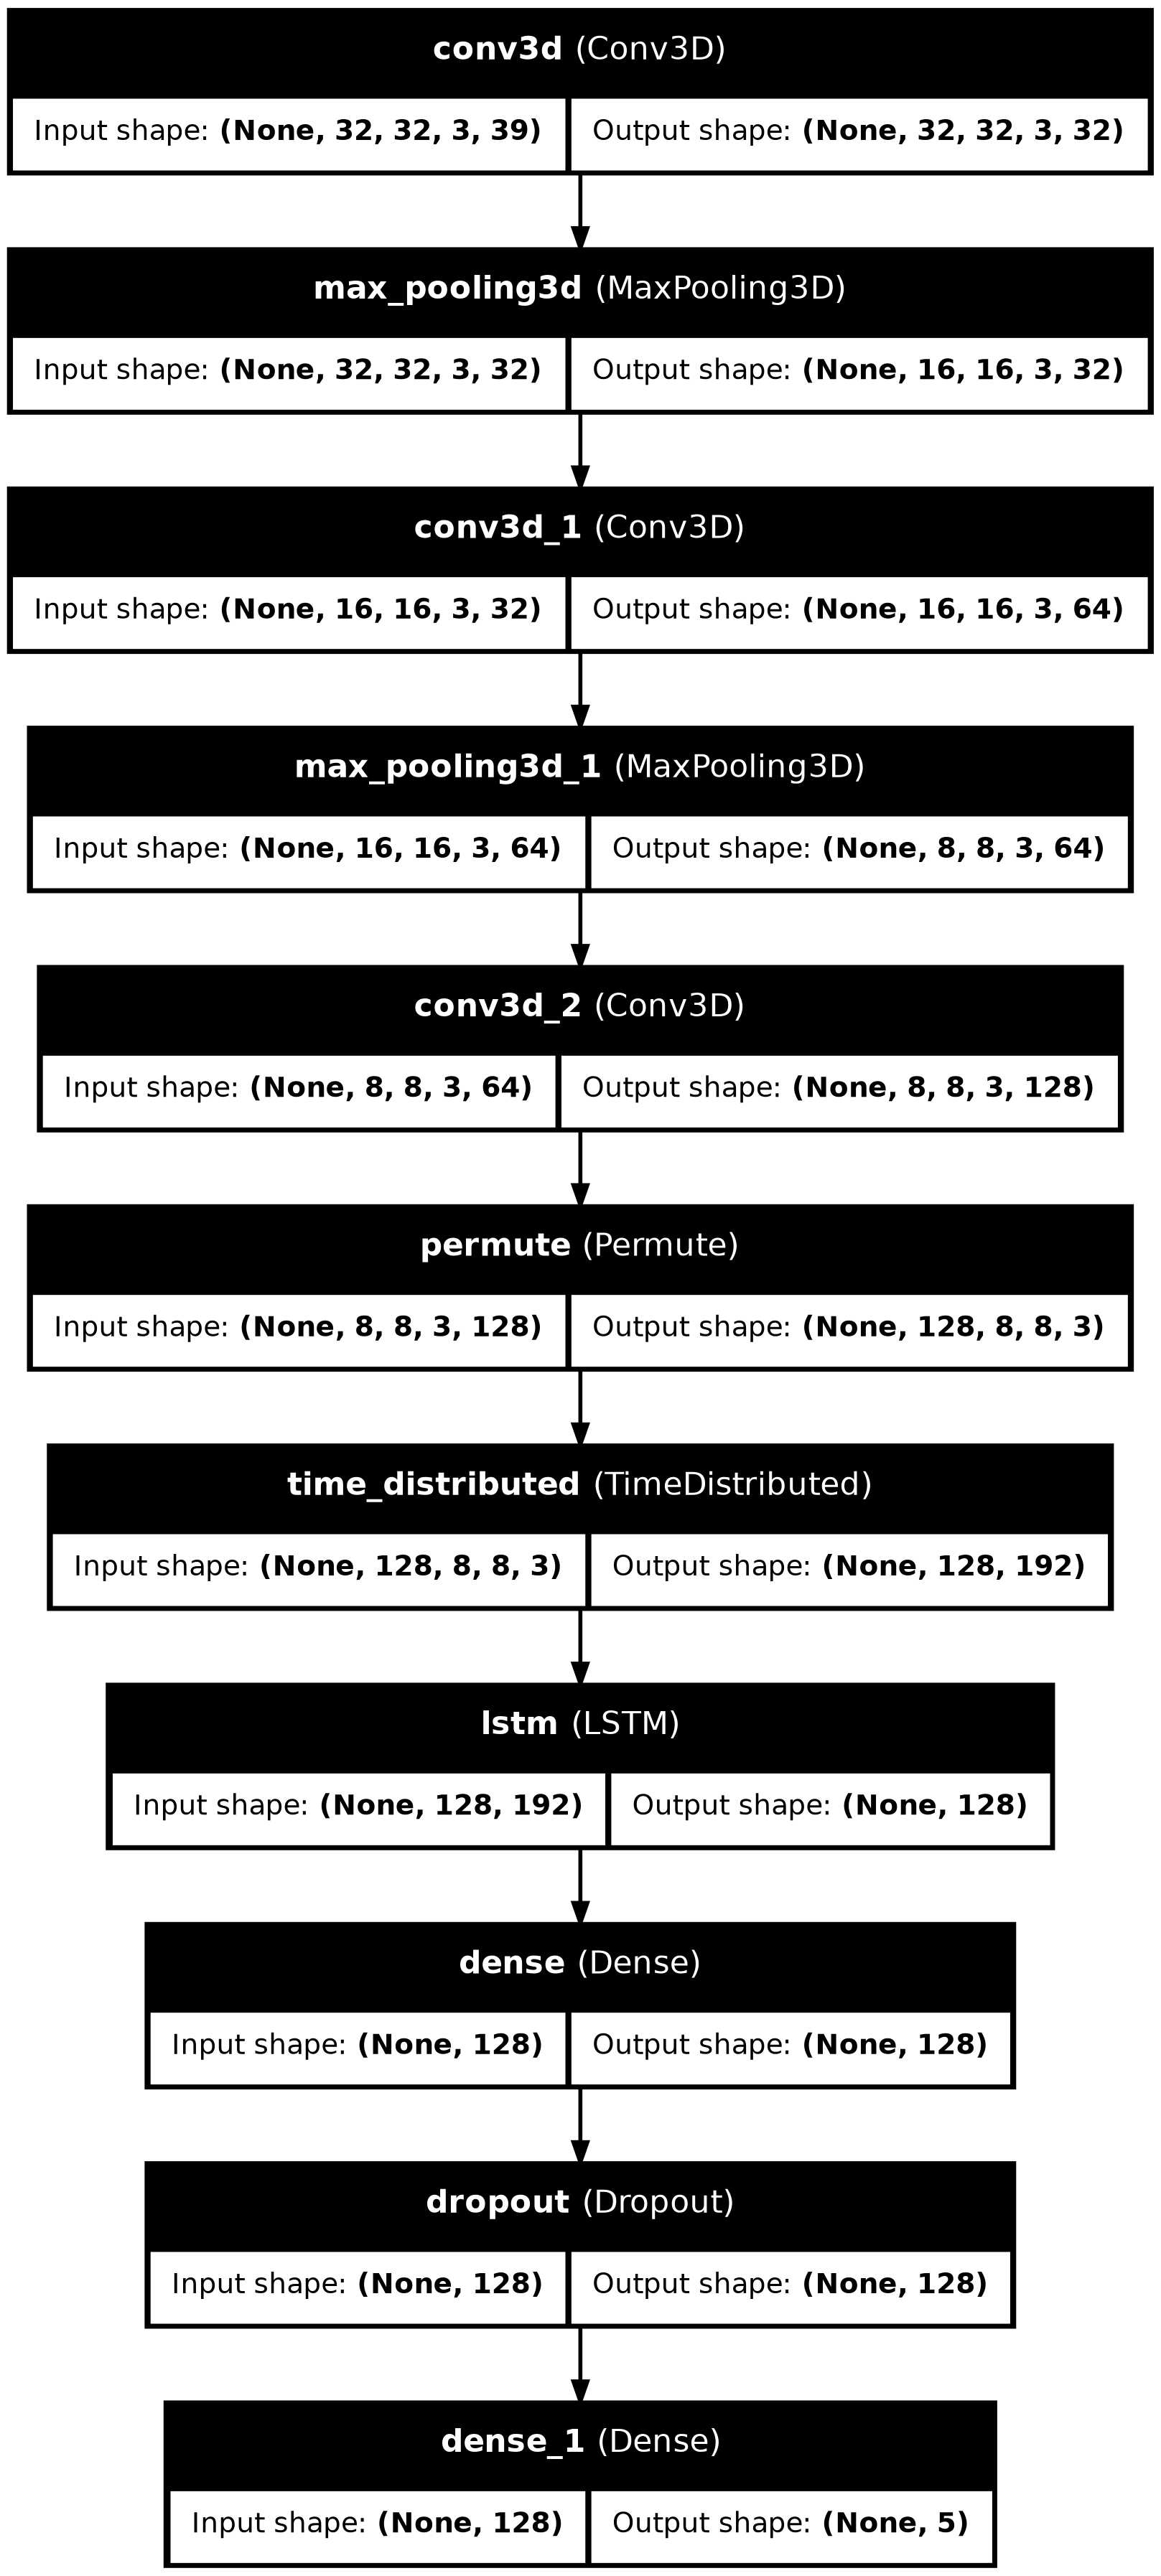

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


In [18]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 32, 32, 3, 32)  │        33,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 16, 16, 3, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 16, 16, 3, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 8, 3, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 8, 3, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 128, 8, 8, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,909 (1.88 MB)

 Trainable params: 491,909 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

### 🧪 Direct Multi-Class Classification with Cross-Validation

We apply 10-fold cross-validation to evaluate the model's ability to classify imagined speech among five classes. Each fold uses 80% of the data for training, 10% for internal validation, and 10% for testing. Accuracy is computed for each fold, and the average is reported.

We use the **direct classification strategy**, where the model learns to distinguish all five imagined words in a single step. Other strategies like nested or binary classification are omitted from this notebook for clarity.



In [19]:
# === Label Preparation
label_indices = utils.to_categorical(
    [np.where(classNames == label)[0][0] for label in labels],
    numClasses
)

# === Data reshaping: [N, H, W, C, T]
topo_maps = np.transpose(topo_maps_rgb_5D, (4, 0, 1, 2, 3))

# === Cross-validation setup
allYPred = []
allYTrue = []
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracy_per_fold = []

totalTime = time.time()

for fold, (trainIdx, testIdx) in enumerate(kf.split(topo_maps)):
    foldTime = time.time()

    # Split data
    XTrain_full, XVal_fold = topo_maps[trainIdx], topo_maps[testIdx]
    YTrain_full, YVal_fold = label_indices[trainIdx], label_indices[testIdx]

    # Further split for internal validation
    val_split = int(0.2 * len(XTrain_full))
    XVal_internal = XTrain_full[:val_split]
    YVal_internal = YTrain_full[:val_split]
    XTrain = XTrain_full[val_split:]
    YTrain = YTrain_full[val_split:]

    # === Train model
    model.fit(
        XTrain, YTrain,
        validation_data=(XVal_internal, YVal_internal),
        batch_size=32,
        epochs=150,
        verbose=1
    )

    # === Evaluate fold
    YPred = np.argmax(model.predict(XVal_fold), axis=1)
    YTrue = np.argmax(YVal_fold, axis=1)

    acc = np.mean(YPred == YTrue)
    accuracy_per_fold.append(acc)
    allYPred.extend(YPred)
    allYTrue.extend(YTrue)

    print(f"Fold {fold+1} Accuracy: {acc*100:.2f}% | Time: {time.time()-foldTime:.2f} seconds")

# === Final summary
totalElapsed = time.time() - totalTime
print(f"\nCross-Validation Average Accuracy: {np.mean(accuracy_per_fold)*100:.2f}%")
print(f"Total Training Time: {totalElapsed:.2f} seconds ({totalElapsed/60:.2f} minutes)")


Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.2510 - loss: 1.6057 - val_accuracy: 0.2222 - val_loss: 1.6026
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2003 - loss: 1.6072 - val_accuracy: 0.2222 - val_loss: 1.6055
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2366 - loss: 1.6054 - val_accuracy: 0.2037 - val_loss: 1.6075
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2382 - loss: 1.6111 - val_accuracy: 0.2222 - val_loss: 1.6056
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2793 - loss: 1.5980 - val_accuracy: 0.2037 - val_loss: 1.6059
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2965 - loss: 1.5924 - val_accuracy: 0.2222 - val_loss: 1.6043
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1879 - loss: 1.6098 - val_accuracy: 0.2222 - val_loss: 1.6035
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2244 - loss: 1.5998 - val_accuracy: 0.2037 - val_loss

# Evaluation

### 📊 Confusion Matrix

The confusion matrix below shows how often each imagined word was correctly or incorrectly predicted across all folds. Rows represent the actual classes, and columns represent the predicted classes.


<Figure size 800x600 with 0 Axes>

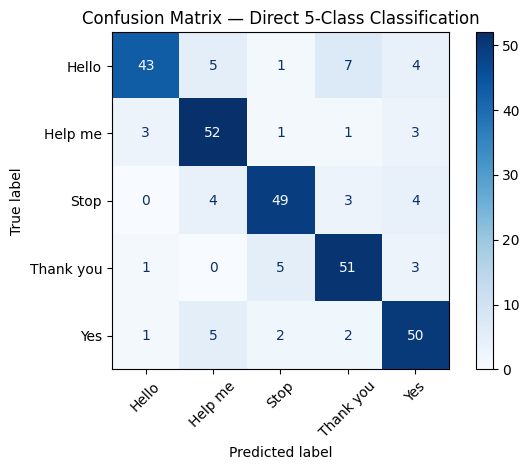

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(allYTrue, allYPred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix — Direct 5-Class Classification")
plt.tight_layout()
plt.show()


### 📈 Per-Class Evaluation Metrics

In addition to accuracy and the confusion matrix, we calculate precision, recall, and F1-score for each class. These metrics help identify class-specific strengths and weaknesses in the model's predictions.


<Figure size 1000x500 with 0 Axes>

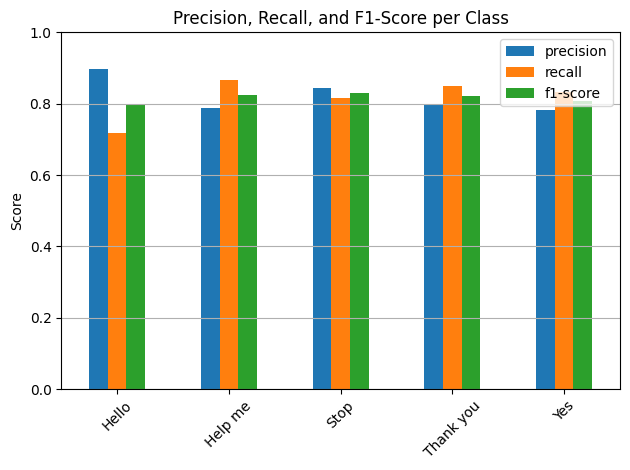

In [27]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

# Generate classification report as dictionary
report = classification_report(allYTrue, allYPred, target_names=classNames, output_dict=True)

# Convert to DataFrame for plotting
df_report = pd.DataFrame(report).transpose()

# Drop overall metrics (support, accuracy, macro avg, weighted avg)
df_report_classes = df_report.iloc[:-3]

# Plot Precision, Recall, F1-Score per class
plt.figure(figsize=(10, 5))
df_report_classes[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🧮 Macro and Weighted Averages

To summarize the model's performance across all classes, we include:
- **Macro Average**: Unweighted mean across all classes, treating each class equally.
- **Weighted Average**: Mean score weighted by class frequency (useful when class imbalance exists).


In [28]:
# Extract macro and weighted averages
macro_avg = df_report.loc["macro avg", ["precision", "recall", "f1-score"]]
weighted_avg = df_report.loc["weighted avg", ["precision", "recall", "f1-score"]]

# Display in a simple table
summary_df = pd.DataFrame({
    "Macro Average": macro_avg,
    "Weighted Average": weighted_avg
})

display(summary_df.round(3))


,Macro Average,Weighted Average
precision,0.821,0.821
recall,0.817,0.817
f1-score,0.816,0.816


### 📈 Evaluation Summary

The code block below summarizes the model’s classification performance using the predictions collected during 10-fold cross-validation.

Specifically, it performs the following:

- **Computes overall accuracy** across all test folds by comparing predicted and true labels.
- **Generates a classification report** with detailed per-class metrics:
  - **Precision**: How many of the predicted labels were correct.
  - **Recall**: How many of the true labels were successfully predicted.
  - **F1-score**: Harmonic mean of precision and recall.
- **Extracts macro average scores**, which treat each class equally regardless of frequency.
- **Extracts weighted average scores**, which take class imbalance into account by weighting scores by support (number of samples).
- **Prints all key metrics** to provide a high-level summary of model performance.


In [23]:
from sklearn.metrics import classification_report, accuracy_score

# === Basic Accuracy
overall_accuracy = accuracy_score(allYTrue, allYPred) * 100
print(f"\n✅ Final Cross-Validation Accuracy: {overall_accuracy:.2f}%")

# === Detailed Metrics
report = classification_report(allYTrue, allYPred, target_names=classNames, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# === Extract macro and weighted averages
macro_avg = df_report.loc["macro avg"]
weighted_avg = df_report.loc["weighted avg"]

print("\n📊 Macro Average Metrics:")
print(macro_avg[["precision", "recall", "f1-score"]].round(3))

print("\n📊 Weighted Average Metrics:")
print(weighted_avg[["precision", "recall", "f1-score"]].round(3))

# === Optional: save report to CSV
# df_report.to_csv("classification_report.csv")



✅ Final Cross-Validation Accuracy: 81.67%

📊 Macro Average Metrics:
precision    0.821
recall       0.817
f1-score     0.816
Name: macro avg, dtype: float64

📊 Weighted Average Metrics:
precision    0.821
recall       0.817
f1-score     0.816
Name: weighted avg, dtype: float64


### 💾 Saving the Trained Model

After training, the model is saved using Keras's built-in `.save()` method. This stores the full model, including:

- Architecture
- Weights
- Optimizer state (if needed)

The model is saved in the HDF5 format (`.h5`) to the Kaggle working directory:

```python
model.save("/kaggle/working/my_model.h5")


In [24]:
model.save("3DCNN+LSTM.h5")


### 🧪 Single-Trial EEG Prediction Demonstration

This cell demonstrates how to use the trained model to classify a **single, unseen EEG trial** from the test set.

#### 🔁 Process Overview:
- A previously trained model (`.h5` format) is loaded from disk.
- A random trial is selected from a test subject's `.mat` file.
- The trial is preprocessed using:
  - **Notch filtering** to remove power-line interference
  - **Common Average Referencing (CAR)** to normalize spatial patterns
- The EEG signal is segmented into overlapping windows.
- Each window is converted into a **topographic RGB brain map** using 2D interpolation.
- The resulting sequence of maps is reshaped to match the model input format.
- The model performs a **prediction**, returning the most likely imagined word class.
- A set of **topographic maps** from the trial is visualized for qualitative inspection.

✅ This step simulates real-world or clinical use, where a single unseen trial is passed through a trained model for classification.


/tmp/ipykernel_1557/2662369311.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet', 256)
/tmp/ipykernel_1557/2662369311.py:44: RuntimeWarning: invalid value encountered in cast
  rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
🎯 Predicted Class for Trial 14: **Help me**


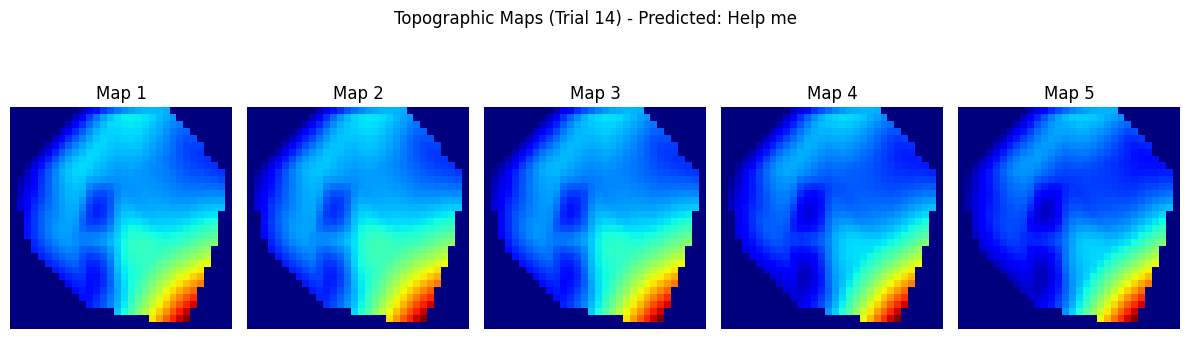

In [25]:
import h5py
import matplotlib.cm as cm

import random
from tensorflow.keras.models import load_model  # ✅ Import the loader

# === Load the trained model (.h5 file saved previously)
model = load_model("3DCNN+LSTM.h5")  # ✅ update with actual path if different

# === Select the subject number used in training (same as before)
subject_id = 1  # e.g., 1 for Data_Sample01
file_path = f"BCI2020 EEG Signal for Words/Test set/Data_Sample{subject_id:02d}.mat"

# === Load the .mat file using h5py
with h5py.File(file_path, 'r') as f:
    epo_test_x = f['epo_test']['x']
    test_data = np.array(epo_test_x).transpose()  # shape: (samples, channels, trials)

# === Get trial count and select one at random
n_trials_test = test_data.shape[2]
random_trial = random.randint(0, n_trials_test - 1)
trial = test_data[:, selected_channels, random_trial]

# === Preprocess trial (Notch filter + CAR)
for ch in range(trial.shape[1]):
    trial[:, ch] = filtfilt(b_notch, a_notch, trial[:, ch])
trial = trial - np.mean(trial, axis=1, keepdims=True)

# === Convert to topographic maps
maps = []
for w in range(start_map-1, end_map):
    start_idx = w * step_samples
    end_idx = start_idx + win_samples
    if end_idx > trial.shape[0]:
        break

    segment = np.mean(trial[start_idx:end_idx, :], axis=0)
    zi = griddata((x_sel.flatten(), y_sel.flatten()), segment,
                  (xi, yi), method='cubic')

    zi_min, zi_max = np.nanmin(zi), np.nanmax(zi)
    zi_norm = (zi - zi_min) / (zi_max - zi_min + np.finfo(float).eps)
    cmap = cm.get_cmap('jet', 256)
    rgb_map = cmap((zi_norm * 255).astype(np.uint8))[:, :, :3]
    maps.append(rgb_map)

# === Prepare model input
maps = np.stack(maps, axis=-1)  # [H, W, 3, T]
maps = np.expand_dims(maps, axis=0)  # [1, H, W, 3, T]

# === Predict
pred_class_idx = np.argmax(model.predict(maps), axis=1)[0]
pred_label = classNames[pred_class_idx]

print(f"🎯 Predicted Class for Trial {random_trial + 1}: **{pred_label}**")

# === Visualize input
plt.figure(figsize=(12, 4))
for i in range(min(5, maps.shape[-1])):  # Show first 5 maps
    plt.subplot(1, 5, i+1)
    plt.imshow(maps[0, :, :, :, i])
    plt.title(f"Map {i + 1}")
    plt.axis('off')

plt.suptitle(f"Topographic Maps (Trial {random_trial + 1}) - Predicted: {pred_label}")
plt.tight_layout()
plt.show()
